Wine quality dataset from: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [1]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', delimiter=';')\
    .load('../data/winequality-white.csv')

In [2]:
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [3]:
df.count()

4898

In [4]:
df.registerTempTable('wine')
sqlContext.sql("SELECT quality, avg(alcohol) AS avg_alcohol FROM wine GROUP BY quality").collect()

[Row(quality=3, avg_alcohol=10.345),
 Row(quality=4, avg_alcohol=10.152453987730064),
 Row(quality=5, avg_alcohol=9.808840082361012),
 Row(quality=6, avg_alcohol=10.575371549893838),
 Row(quality=7, avg_alcohol=11.367935606060609),
 Row(quality=8, avg_alcohol=11.635999999999997),
 Row(quality=9, avg_alcohol=12.18)]

In [5]:
data = sqlContext.sql("SELECT *, CAST(quality AS DOUBLE) AS label FROM wine")
data.cache()

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int, label: double]

Let's try some machine learning

Let's visualise data using PCA for dimensinality reduction

In [6]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline


all_assembler = VectorAssembler(
    inputCols=["sulphates", "density", "alcohol"],
#    inputCols=map(lambda s:s.name,df.schema.fields)[:-1],
    outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="norm_features")
pca = PCA(k=2, inputCol="norm_features", outputCol="pca_features")

pca_pipeline = Pipeline(stages=[all_assembler, normalizer, pca])

pca_model = pca_pipeline.fit(data)

pca_model.transform(data).first()

Row(fixed acidity=7.0, volatile acidity=0.27, citric acid=0.36, residual sugar=20.7, chlorides=0.045, free sulfur dioxide=45.0, total sulfur dioxide=170.0, density=1.001, pH=3.0, sulphates=0.45, alcohol=8.8, quality=6, label=6.0, features=DenseVector([0.45, 1.001, 8.8]), norm_features=DenseVector([0.0507, 0.1129, 0.9923]), pca_features=DenseVector([-0.013, -0.0169]))

In [7]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


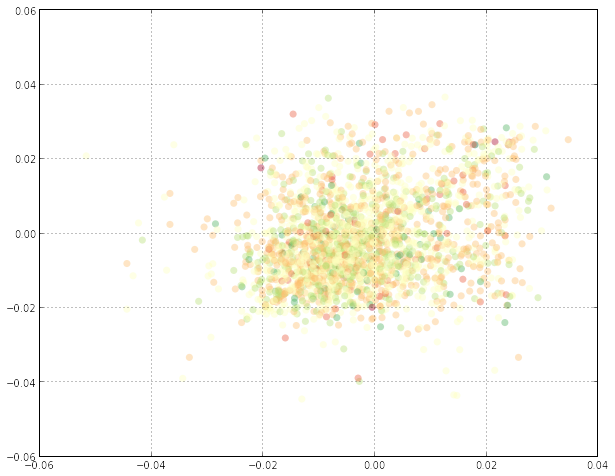

In [8]:
import matplotlib.pyplot as plt
pca_data = pca_model.transform(data)

sampling_fraction = 0.5

pca_xy = np.matrix(map(lambda r:r.pca_features.array, pca_data.sample(False, sampling_fraction, 13).collect()))
pca_colors = map(lambda r: float(r.quality),data.select('quality').sample(False, sampling_fraction, 13).collect())

plt.scatter(pca_xy[:,0], pca_xy[:,1], c=pca_colors, alpha=0.4, cmap=plt.get_cmap('RdYlGn'), edgecolors='none', s=50)
plt.grid(True)
plt.show()

In [9]:
tweets_df = sqlContext.read.format('json').load('../data/tweets.json')

In [10]:
tweets_df.printSchema()

root
 |-- CAPTURED_AT: string (nullable = true)
 |-- CAPTURE_ID: long (nullable = true)
 |-- COUNT: long (nullable = true)
 |-- CREATED_AT: string (nullable = true)
 |-- FOLLOWERS: long (nullable = true)
 |-- FRIENDS: long (nullable = true)
 |-- FROM_USER_NAME: string (nullable = true)
 |-- ID: long (nullable = true)
 |-- IN_REPLY_TO_STATUS_ID: long (nullable = true)
 |-- LANGUAGE: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ORIGINAL_TWEET_ID: long (nullable = true)
 |-- ORIGINAL_TWEET_LOCATION: string (nullable = true)
 |-- PROFILE_IMAGE_URL: string (nullable = true)
 |-- PROFILE_IMAGE_URL_HTTPS: string (nullable = true)
 |-- RETWEET_FLAG: string (nullable = true)
 |-- SCREEN_NAME: string (nullable = true)
 |-- TEXT: string (nullable = true)
 |-- TIME_ZONE: string (nullable = true)
 |-- TO_USER: string (nullable = true)
 |-- TO_USER_ID: long (nullable = true)
 |-- USER_CREATED_AT

In [11]:
tweets_df.registerTempTable('tweets')
sqlContext.sql("SELECT USER_ID,count(*) AS TWEET_COUNT FROM tweets GROUP BY USER_ID ORDER BY TWEET_COUNT DESC LIMIT 10").show()

+----------+-----------+
|   USER_ID|TWEET_COUNT|
+----------+-----------+
|1453297176|        102|
| 580015607|         39|
| 205017583|         35|
|1572619639|         30|
| 181850130|         28|
| 716250518|         27|
|1482287886|         26|
|2375513360|         24|
|  70295221|         23|
|  32654228|         23|
+----------+-----------+



In [12]:
tweets_df.groupBy("USER_ID").count().show()

+----------+-----+
|   USER_ID|count|
+----------+-----+
| 498751231|    2|
| 158404031|    1|
|  42512231|    3|
| 230842431|    4|
| 255979431|    2|
| 591369831|    2|
|1607517631|    3|
| 340544431|    3|
| 484155631|    2|
|2278591327|    1|
| 802130232|    3|
|2180030328|    1|
|  30258232|    1|
| 826340832|    1|
|  96380232|    1|
|1616197832|    1|
|1465446632|    2|
|  23405232|    1|
|2416899529|    1|
| 234113433|    9|
+----------+-----+
only showing top 20 rows



In [13]:
tweets_df.write.format("parquet").save("target/tweets.parquet", mode='overwrite')